# Autoencoders

* Una red neuronal compuesta por dos partes:
    * Un _encoder_ network que comprime input data de alta dimension a una representacion vectorial de baja dimension
    * Un _decoder_ network que decomprime una representacion vectorial dada de regreso al dominio original

![Diagrama de Autoencoder](../assets/autoencoder.png)

* La red esta entrenada para encontrar los pesos para el encoder y decoder que minimizan el loss entre
    * el input original
    * la reconstruccion del input
* El vector de representacion es una compresion de la imagen original a un espacio latente con baja dimensionalidad.
* La idea es que al escoger _cualquier_ punto en el espacio latente, deberiamos poder generar imagenes nuevas al pasar este punto a traves del decoder.
    * Porque el decoder aprendio el mapa: puntos en espacio latente -> imagenes viables

Vamos a empezar construyendo un autoencoder simple para comprimir el dataset de MNIST. Con autoencoders, pasamos input data a traves del encoder que crea la representacion comprimida del input. Luego, esta representacion pasa a traves del decoder para reconstruir la data de input. Generalmente el encoder y decoder se construyen usando NNs, luego se entrenan en data de ejemplos.

## Representacion comprimida

Una representacion comprimida puede ser buena para guardar y compartir cualquier tipo de data en una forma que sea mas eficiente que guardar la data cruda. En la practica, la representacion comprimida contiene informacion clave sobre la imagen de input y la podemos usar para reconstruir, denoising y otras transformaciones.

En este notebook vamos a construir una simple NN para el encoder y decoder.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convertira data a torch.FloatTensor
transform = transforms.ToTensor()

# cargar los datasets de training y test
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

100%|█████████▉| 9904128/9912422 [02:18<00:00, 117483.25it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 113296.12it/s]           


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 18%|█▊        | 294912/1648877 [00:06<00:53, 25272.55it/s]
9920512it [02:30, 117483.25it/s]                             
100%|█████████▉| 1646592/1648877 [00:46<00:00, 67670.30it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz




0it [00:00, ?it/s]

8192it [00:00, 54148.37it/s]            


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [2]:
# Crear los dataloaders para training y test
# numero de subprocesses para usar para cargar la data
num_workers = 0
# numero de muestras por batch para cargar
batch_size = 20

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualizar la data


1654784it [00:58, 67670.30it/s]                             

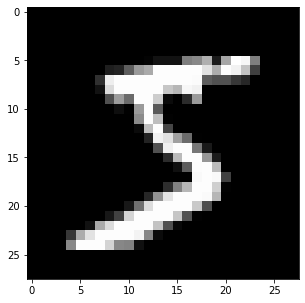

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Autoencoder lineal

Vamos a entrenar un autoencoder con estas imagenes aplanandolas a vectores de largo 784. Las imagenes de este dataset ya estan normalizadas para que sus valores esten entre 1 y 0. El encoder y decoder deberian estar hechos de **una capa lineal**. Las unidades que conectan el encoder y decoder van a ser la _representacion comprimida_.

Como las imagenes estan normalizadas, necesitamos usar una activacion **sigmoid** en la capa de output para obtener valores que se encuentren en el mismo rango que el input.

**TODO: Construir el autoencoder en la celda de abajo**
> Las imagenes de input deben ser aplanadas a vectores de 784. Los targets son los mismos que los inputs. El encoder y el decoder van a estar hechos de dos capas lineales cada uno. La profundidad de las dimensiones deben cambiar de la siguiente forma: 784 inputs -> **encoding_dims** -> 784 outputs. Todas las capas deben tener activaciones ReLu aplicadas excepto por la capa final que debe ser un sigmoid

**La representacion comprimida debe ser un vector con dimension `encoding_dim=32`**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Definir arquitectura
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        
        

    def forward(self, x):
        # definir feedforward
        x = F.relu(self.fc1(x))
        # aplicar sigmoid al output layer
        x = F.sigmoid(self.fc2(x))
        
        return x

# inicializar NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


### Entrenamiento

El resto es codigo para entrenamiento, deberia resultarles familiar. En este caso no nos interesa mucho la validacion, asi que solo vamos a monitorear el training loss y el test loss.

Tampoco nos preocupamos por los labels en este caso. Como estamos comparando valores de pixeles en las imagenes de input y output, lo mejor es usar una los que sea util para tareas de regresion. La regresion se utiliza para comparar _cantidades_ en vez de valores probabilisticos. En este caso vamos a usar `MSELoss`. 

In [5]:
# especificar loss function
criterion = nn.MSELoss()

# especificar optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# numero de epochs para entrenar el modelo
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # training loss
    train_loss = 0.0
    
    ######################
    # entrenar el modelo #
    ######################
    for data in train_loader:
        # _ para los labels (como no nos interesan)
        images, _ = data
        # aplanar imagenes
        images = images.view(images.size(0), -1)
        # limpiar las gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcular valores predecidos
        outputs = model(images)
        # calcular el loss
        loss = criterion(outputs, images)
        # backward pass: calcular gradiente del los con respecto al modelo
        loss.backward()
        # realizar un unico paso de optimizacion (actualizar parametros)
        optimizer.step()
        # actualizar training loss acumulado
        train_loss += loss.item()*images.size(0)
            
    # print estadisticas de entrenamiento
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

C:\Users\ajuar\Miniconda3\envs\ai\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.681662
Epoch: 2 	Training Loss: 0.350823
Epoch: 3 	Training Loss: 0.308606
Epoch: 4 	Training Loss: 0.298858
Epoch: 5 	Training Loss: 0.294545
Epoch: 6 	Training Loss: 0.292122
Epoch: 7 	Training Loss: 0.290748
Epoch: 8 	Training Loss: 0.289797
Epoch: 9 	Training Loss: 0.288998
Epoch: 10 	Training Loss: 0.288314
Epoch: 11 	Training Loss: 0.287726
Epoch: 12 	Training Loss: 0.287184
Epoch: 13 	Training Loss: 0.286666
Epoch: 14 	Training Loss: 0.286162
Epoch: 15 	Training Loss: 0.285713
Epoch: 16 	Training Loss: 0.285208
Epoch: 17 	Training Loss: 0.284758
Epoch: 18 	Training Loss: 0.284362
Epoch: 19 	Training Loss: 0.283982
Epoch: 20 	Training Loss: 0.283618


### Revisar los resultados

El codigo de abajo son plots de las imagenes de entrenamiento con sus reconstrucciones. 

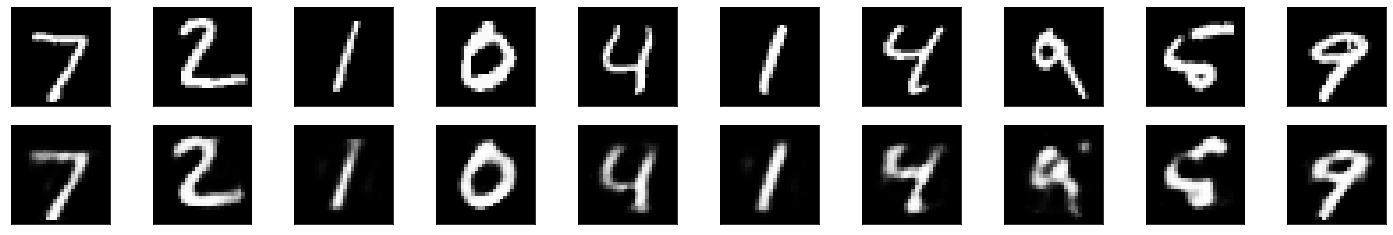

In [7]:
# obtener un batch del test set
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# sample outputs
output = model(images_flatten)
# preparar imagenes para display
images = images.numpy()

# output es redimensionado a un batch de imagenes
output = output.view(batch_size, 1, 28, 28)
# usar detach cuando es un output que requires_grad=False
output = output.detach().numpy()

# plot las primeras 10 input images y luego reconstruir las imagenes
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# inputs arriba, reconstrucciones abajo
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Estamos tratando con imagenes, por lo que (usualmente) obtendriamos mejor performance usando convolution layers.

## Convolutional Autoencoder

Siguiendo con el dataset de MNIST, vamos a mejorar el performance del autoencoder usando convolutional layers. Vamos a construir un autoencoder para comprimir el dataset de MNIST.
> La porcion del encoder estara compuesta de convolutional y pooling layers y el decoder va a estar hecho de **transpose convolutional layers** que aprenden a "upsample" la representacion comprimida.

In [8]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [9]:
num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

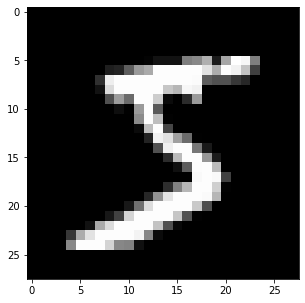

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Arquitectura

**Encoder**

La parte de la red para el encoder va a ser una tipica piramide de convolutions. Cada convolutional layer va a ser seguida por un layer de max-pooling para reducir las dimensiones de los layers.

**Decoder**

El decoder si es algo nuevo. El decoder necesita convertir una representacion estrecha a una imagen ancha reconstruida. Por ejemplo, la representacion puede ser un max-pool layer de 7x7x4. Este es el outpu del encoder, pero tambien el input para el encoder. Queremos obtener una imagen de 28x28x1 de este decoder. 

![autoencoder architecture](../assets/conv_enc_1.png)

Nuestra ultima layer del encoder tiene un tamanio de 7x7x4 = 196. Las imagenes originales tienen tamanio 28x28 = 784, asi que el encoded vector es 25% el tamanio de la imagen original. Estos son solamente tamanios sugeridos para cada layer. Intenten cambiar las depths y sizes y agregar layers adicionales para hacer esta representacion hasta mas pequenia. Nuestra meta aqui es encontrar una representacion pequenia del input data.

### Transpose convolutions, Decoder

Este decoder usa **transposed convolutional** layers para incrementar el ancho y altura de las input layers. Funcionan casi exactamente igual que las convolutional layers, pero en reversa. Un stride en el input layer resulta en un stride mas largo en el transposed convolution layer. Por ejemplo, si tenemos un kernel de 3x3, un patch de 3x3 en el input layer va a ser reducido a una unidad en el convolutional layer. Asimismo, una unidad en el input layer se va a expandir a un patch de 3x3 en un transposed convolution layer. PyTorch nos provee con una forma facil de crear los layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d).

Es importante notar que los transpose convolution layers pueden introducir artefactos en las imagenes finales, como patrones cuadriculados. Esto se debe al overlap en los kernels los cuales pueden ser evitados configurando el tamanio del stride y el kernel para que sean del mismo tamanio. En este [articulo de Distill](http://distill.pub/2016/deconv-checkerboard/) de Augustus Odena, _et. al_, los autores demuestran como estos artefactos pueden ser evitados.

**TODO: Desarrollar la red**
> Construir el encoder compuesto de una serie de convolutional y pooling layers. Cuando construyan el decoder, recuerden que los transpose convolutional layers pueden upsample un input por un factor de 2 usando un stride y un kernel_size de 2.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# definir la arquitectura
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 18), 2x2 kernels
        self.conv1 = nn.Conv2d(1, 16, 2, padding=1)  
        # conv layer (depth from 18 --> 3), 2x2 kernels
        self.conv2 = nn.Conv2d(16, 4, 2, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        
        ## decoder layers ##
        ## un kernel de 2 y un stride de 2 van a incrementar las dims por 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)



    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
       
        # output layer (with sigmoid for scaling from 0 to 1)
        
        ## aplicar ReLu a todas las hidden layers excepto el output layer
        x = F.relu(self.t_conv1(x))
        ## aplicar sigmoid al output layer
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# inicializar el NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [12]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 30

for epoch in range(1, n_epochs+1):

    train_loss = 0.0

    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.796160
Epoch: 2 	Training Loss: 0.347972
Epoch: 3 	Training Loss: 0.317842
Epoch: 4 	Training Loss: 0.307885
Epoch: 5 	Training Loss: 0.302692
Epoch: 6 	Training Loss: 0.296641
Epoch: 7 	Training Loss: 0.288688
Epoch: 8 	Training Loss: 0.284409


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))


for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)